# Explore distribution functions

In [26]:
import torch
from math import log

l = torch.tensor([log(0.8), log(0.1), log(0.1)])
dist = torch.distributions.categorical.Categorical(logits = l)
s = dist.sample((10000,))

(s.view(-1, 1) == torch.arange(3).view(1, -1)).float().mean(0)

tensor([0.7992, 0.0997, 0.1011])

In [28]:
l = torch.tensor([[log(0.9), log(0.1)],
                  [log(0.5), log(0.5)],
                  [log(0.25), log(0.75)],
                  [log(0.01), log(0.99)]])

dist = torch.distributions.categorical.Categorical(logits = l)
dist.sample((8,))

tensor([[0, 1, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1]])

# Constructing the nerual net

In [53]:
from torch import nn
t_value = 32

class Net(nn.Module):
    def __init__(self, nb_values):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(320, 200),
            nn.ReLU(),
            nn.Linear(200, nb_values),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [55]:
model = Net(nb_values = 2 * t_value)
sequence = torch.zeros(1, 2, t_value)
output = model(sequence)
output.size()

torch.Size([1, 64])

# Generating training data

In [102]:
import torch.nn.functional as F

def generate_training_data(nb_samples, T):
    slope_1 = torch.rand(nb_samples, 1) * 2 - 1
    slope_2 = torch.rand(nb_samples, 1) * 2 - 1
    cut_off = torch.randint(1, T, (nb_samples, 1))

    indexes = torch.arange(T).view(1, -1)
    seg_1 = ((indexes < cut_off).int() * indexes * slope_1).long()
    seg_2 = (F.relu(indexes - cut_off) * slope_2).long()

    return seg_1 + seg_2 + T


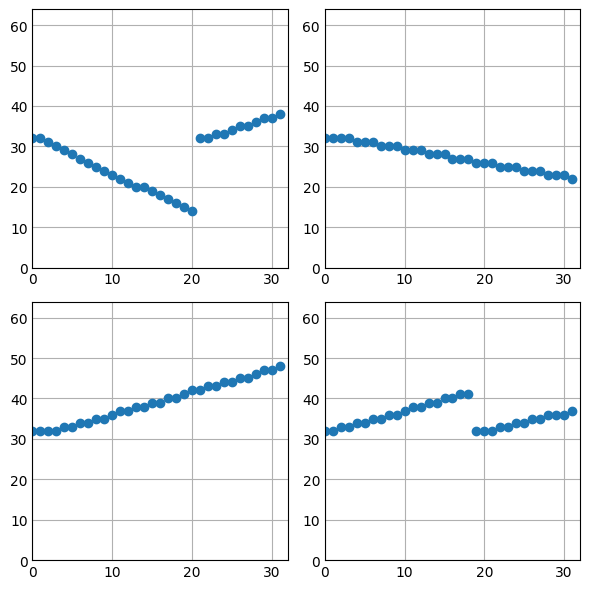

In [114]:
import matplotlib.pyplot as plt


def print_sequences(sequences, nb_rows, nb_cols):
    fig, ax = plt.subplots(nb_rows, nb_cols, figsize=(nb_rows * 3, nb_cols * 3))
    for i in range(nb_rows):
        for j in range(nb_cols):
            ax[i, j].scatter(torch.arange(t_value), sequences[i * nb_cols + j])
            ax[i, j].set(xlim=(0, t_value), ylim=(0, 2 * t_value))
    
    fig.tight_layout()
    plt.show()


data = generate_training_data(nb_rows * nb_cols, t_value)
print_sequences(data, 2, 2)


# Training

In [112]:
nb_epochs = 10
nb_samples = 10000
batch_size = 100

model = Net(nb_values = 2 * t_value)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
training_sequences = generate_training_data(nb_samples, t_value)

mean = training_sequences.float().mean(0)
std = training_sequences.float().std(0) + 0.0001

for epoch in range(nb_epochs):
    print(f'Entering epoch {epoch}')
    batch = 0
    for sequences in training_sequences.split(batch_size):
        batch += 1
        # print(f'Entering training batch {batch}')
    
        nb = sequences.size(0)
    
        idx = torch.randint(t_value, (nb, 1))
        targets = sequences.gather(1, idx).view(-1)
    
        tics = torch.arange(t_value).view(1, -1).expand(nb, -1)
        masks = (tics < idx.expand(-1, t_value)).float()
        values = (sequences - mean) / std * masks
        
        input = torch.cat((masks.unsqueeze(1), values.unsqueeze(1)), 1)
    
        output = model(input)
        loss = F.cross_entropy(output, targets)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        print(f'finishing training batch {batch}, samples = {nb}, loss = {loss:2f}')


Entering epoch 0
finishing training batch 1, samples = 100, loss = 4.162196
finishing training batch 2, samples = 100, loss = 3.909431
finishing training batch 3, samples = 100, loss = 3.718381
finishing training batch 4, samples = 100, loss = 3.305348
finishing training batch 5, samples = 100, loss = 3.466076
finishing training batch 6, samples = 100, loss = 3.231081
finishing training batch 7, samples = 100, loss = 3.111703
finishing training batch 8, samples = 100, loss = 2.745557
finishing training batch 9, samples = 100, loss = 3.189336
finishing training batch 10, samples = 100, loss = 3.237962
finishing training batch 11, samples = 100, loss = 3.039349
finishing training batch 12, samples = 100, loss = 3.089674
finishing training batch 13, samples = 100, loss = 3.107237
finishing training batch 14, samples = 100, loss = 2.975990
finishing training batch 15, samples = 100, loss = 2.866563
finishing training batch 16, samples = 100, loss = 2.710329
finishing training batch 17, sam

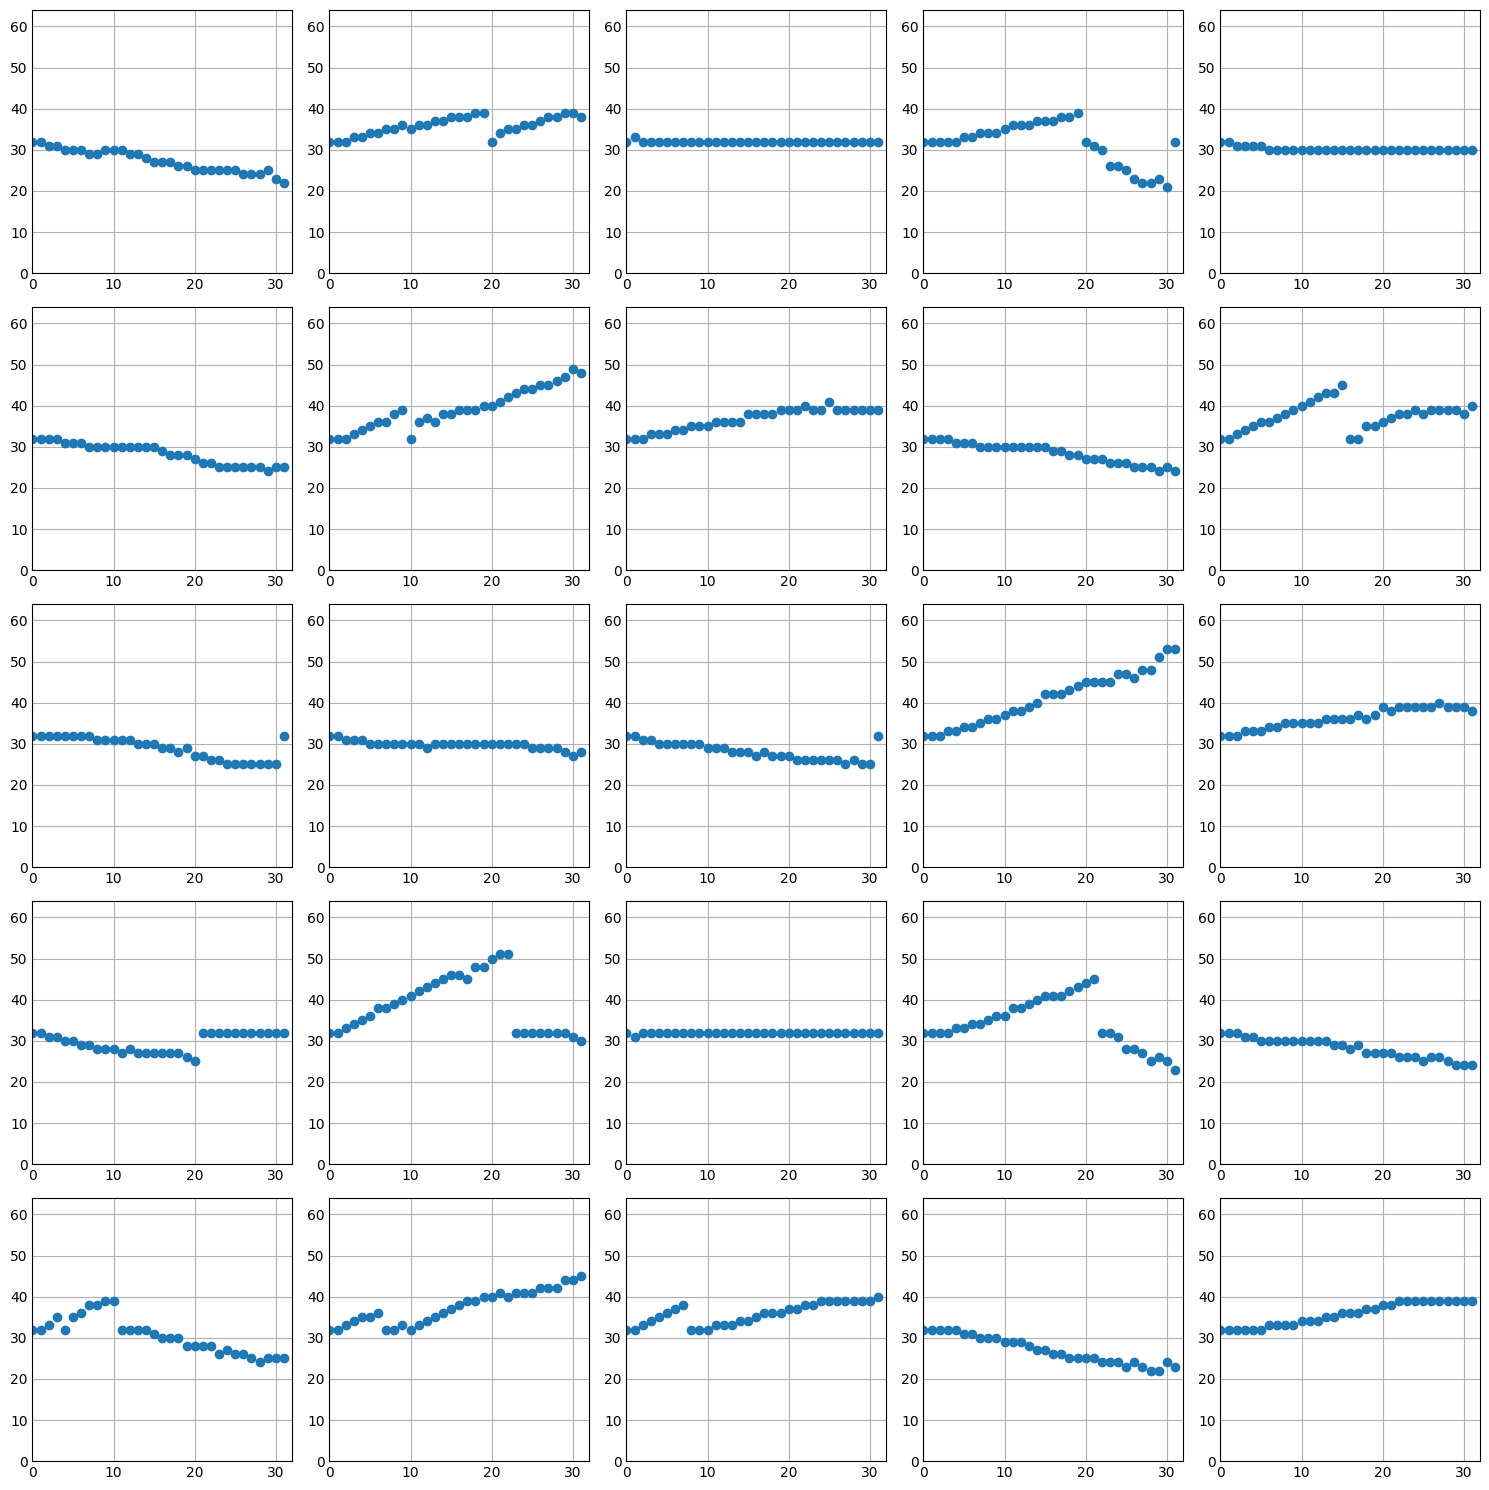

In [115]:
nb = 25

generated = torch.zeros(nb, t_value)
tics = torch.arange(t_value).view(1, -1).expand(nb, -1)

for t in range(t_value):
    masks = (tics < t).float()
    values = (generated - mean) / std * masks

    input = torch.cat((masks.unsqueeze(1), values.unsqueeze(1)), 1)
    output = model(input)

    dist = torch.distributions.categorical.Categorical(logits = output)
    generated[:,t] = dist.sample()

print_sequences(generated, 5, 5)